In [1]:
# import libraries
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
import numpy as np
import xgboost as xgb
import os
import glob
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import joblib

In [2]:
def load_existing_coin_data(data_folder=None):
    """
    Load all coin CSV files from the data folder and combine them
    """
    if data_folder is None:
        data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
    
    print(f"Loading coin data from {data_folder} folder...")
    print(f"Full data path: {data_folder}")
    
    # Get all CSV files in the data folder
    coin_files = glob.glob(os.path.join(data_folder, 'coin_*.csv'))
    print(f"Found {len(coin_files)} coin files")
    
    if len(coin_files) == 0:
        print("No coin files found! Check your data folder path.")
        return None
    
    all_data = []
    success_count = 0
    
    # Process each file
    for file_path in coin_files:
        try:
            # Extract coin name from filename
            coin_name = os.path.basename(file_path).replace('coin_', '').replace('.csv', '')
            
            # Load the data
            df = pd.read_csv(file_path)
            
            # Check for essential columns
            if not all(col in df.columns for col in ['date', 'price', 'market_cap', 'volume']):
                missing_cols = [col for col in ['date', 'price', 'market_cap', 'volume'] if col not in df.columns]
                print(f"Missing columns in {coin_name}: {missing_cols}. Skipping.")
                continue
            
            # Rename 'date' to 'timestamp' for consistency with our code
            df['timestamp'] = pd.to_datetime(df['date'])
            
            # Add the coin identifier
            df['coin'] = coin_name
            
            all_data.append(df)
            success_count += 1
            
            # Print progress periodically
            if success_count % 100 == 0:
                print(f"Loaded {success_count} files so far...")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Combine all dataframes
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"Successfully loaded data for {len(set(combined_df['coin']))} coins")
        print(f"Total rows: {len(combined_df)}")
        return combined_df
    else:
        print("No data could be loaded!")
        return None

In [3]:
def feature_engineering(df):
    # Sort data per coin and timestamp
    df = df.sort_values(by=['coin', 'timestamp'])
    
    # Create future price column
    df['future_price_60d'] = df.groupby('coin')['price'].shift(-60)
    
    # Define success label - will price double in 60 days
    df['success'] = (df['future_price_60d'] >= 2 * df['price']).astype(int)
    
    # ---------- BASIC FEATURES ----------
    # Price momentum
    df['price_change_1d'] = df.groupby('coin')['price'].pct_change(1)
    df['price_change_7d'] = df.groupby('coin')['price'].pct_change(7)
    df['price_change_14d'] = df.groupby('coin')['price'].pct_change(14)
    df['price_change_30d'] = df.groupby('coin')['price'].pct_change(30)
    df['price_change_90d'] = df.groupby('coin')['price'].pct_change(90)
    
    # Volume trends
    df['volume_change_1d'] = df.groupby('coin')['volume'].pct_change(1)
    df['volume_change_7d'] = df.groupby('coin')['volume'].pct_change(7)
    df['volume_rolling_mean_7d'] = df.groupby('coin')['volume'].rolling(window=7).mean().reset_index(0, drop=True)
    df['volume_rolling_mean_30d'] = df.groupby('coin')['volume'].rolling(window=30).mean().reset_index(0, drop=True)
    
    # Volatility (standard deviation of price)
    df['volatility_7d'] = df.groupby('coin')['price'].rolling(window=7).std().reset_index(0, drop=True)
    df['volatility_14d'] = df.groupby('coin')['price'].rolling(window=14).std().reset_index(0, drop=True)
    df['volatility_30d'] = df.groupby('coin')['price'].rolling(window=30).std().reset_index(0, drop=True)
    
    # Moving average comparison
    df['ma_7'] = df.groupby('coin')['price'].rolling(window=7).mean().reset_index(0, drop=True)
    df['ma_30'] = df.groupby('coin')['price'].rolling(window=30).mean().reset_index(0, drop=True)
    df['ma_diff'] = df['ma_7'] - df['ma_30']
    df['ma_ratio'] = df['ma_7'] / df['ma_30']  # Alternative representation

    # ---------- TECHNICAL INDICATORS ----------
    # RSI (Relative Strength Index)
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        # Handle division by zero
        avg_loss = avg_loss.replace(0, np.finfo(float).eps)
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['rsi_14'] = df.groupby('coin')['price'].apply(calculate_rsi).reset_index(0, drop=True)
    
    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df.groupby('coin')['price'].ewm(span=12, adjust=False).mean().reset_index(0, drop=True)
    df['ema_26'] = df.groupby('coin')['price'].ewm(span=26, adjust=False).mean().reset_index(0, drop=True)
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df.groupby('coin')['macd'].ewm(span=9, adjust=False).mean().reset_index(0, drop=True)
    df['macd_histogram'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['bollinger_mid'] = df['ma_30']  # Using 30-day MA as middle band
    df['bollinger_std'] = df.groupby('coin')['price'].rolling(window=30).std().reset_index(0, drop=True)
    df['bollinger_upper'] = df['bollinger_mid'] + (df['bollinger_std'] * 2)
    df['bollinger_lower'] = df['bollinger_mid'] - (df['bollinger_std'] * 2)
    df['bollinger_width'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['bollinger_mid']
    df['bollinger_pct'] = (df['price'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])

    # On-Balance Volume (OBV)
    def calculate_obv(group):
        obv = pd.Series(index=group.index, dtype='float64')
        obv.iloc[0] = 0
        
        for i in range(1, len(group)):
            if group.iloc[i]['price'] > group.iloc[i-1]['price']:
                obv.iloc[i] = obv.iloc[i-1] + group.iloc[i]['volume']
            elif group.iloc[i]['price'] < group.iloc[i-1]['price']:
                obv.iloc[i] = obv.iloc[i-1] - group.iloc[i]['volume']
            else:
                obv.iloc[i] = obv.iloc[i-1]
        
        return obv
    
    # Calculate OBV for each coin separately
    for coin in df['coin'].unique():
        coin_mask = df['coin'] == coin
        df.loc[coin_mask, 'obv'] = calculate_obv(df[coin_mask])
    
    # OBV momentum
    df['obv_change_7d'] = df.groupby('coin')['obv'].pct_change(7)
    df['obv_change_30d'] = df.groupby('coin')['obv'].pct_change(30)

    # ---------- MARKET CONTEXT FEATURES ----------
    # Market Cap to Volume Ratio
    df['mcap_to_volume_ratio'] = df['market_cap'] / df['volume']
    
    # Price to Market Cap ratio (a form of "price to value" measure)
    df['price_to_mcap_ratio'] = df['price'] / df['market_cap']
    
    # ---------- PRICE PATTERN FEATURES ----------
    # Calculate All-Time High (ATH) within the available window
    df['rolling_max'] = df.groupby('coin')['price'].cummax()
    df['ath_ratio'] = df['price'] / df['rolling_max']
    
    # Recent drawdown - drop from recent high
    df['high_30d'] = df.groupby('coin')['price'].rolling(window=30).max().reset_index(0, drop=True)
    df['drawdown_30d'] = (df['price'] - df['high_30d']) / df['high_30d']
    
    # Days since local bottom/top
    def days_since_extreme(group, window=30, find_max=True):
        if find_max:
            rolling_extreme = group['price'].rolling(window=window).max()
        else:
            rolling_extreme = group['price'].rolling(window=window).min()
        
        # Find indices where price equals the rolling extreme
        extreme_indices = group.index[group['price'] == rolling_extreme]
        
        # For each row, find days since the most recent extreme
        days_since = pd.Series(index=group.index, dtype='float64')
        for idx in group.index:
            prior_extremes = extreme_indices[extreme_indices < idx]
            if len(prior_extremes) > 0:
                days_since.loc[idx] = (idx - prior_extremes.max())
            else:
                days_since.loc[idx] = np.nan
        
        return days_since
    
    # Calculate days since local top/bottom for each coin separately
    for coin in df['coin'].unique():
        coin_mask = df['coin'] == coin
        df.loc[coin_mask, 'days_since_peak_30d'] = days_since_extreme(df[coin_mask], window=30, find_max=True)
        df.loc[coin_mask, 'days_since_bottom_30d'] = days_since_extreme(df[coin_mask], window=30, find_max=False)

    # ---------- TIME-BASED FEATURES ----------
    # Basic date components
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    return df

In [4]:
df_raw = load_existing_coin_data()

df_features = feature_engineering(df_raw)

Loading coin data from /Users/jawaadahmar/Desktop/projects/crypto-currency-price-predictor/data folder...
Full data path: /Users/jawaadahmar/Desktop/projects/crypto-currency-price-predictor/data
Found 2000 coin files
Loaded 100 files so far...
Loaded 200 files so far...
Loaded 300 files so far...
Loaded 400 files so far...
Loaded 500 files so far...
Loaded 600 files so far...
Loaded 700 files so far...
Loaded 800 files so far...
Loaded 900 files so far...
Loaded 1000 files so far...
Loaded 1100 files so far...
Missing columns in list: ['date', 'price', 'volume']. Skipping.
Loaded 1200 files so far...
Loaded 1300 files so far...
Loaded 1400 files so far...
Loaded 1500 files so far...
Loaded 1600 files so far...
Loaded 1700 files so far...
Loaded 1800 files so far...
Loaded 1900 files so far...
Successfully loaded data for 1999 coins
Total rows: 576934


In [5]:
# check if structure is correct
df_features.head()

,date,price,market_cap,volume,timestamp,coin,future_price_60d,success,price_change_1d,price_change_7d,...,rolling_max,ath_ratio,high_30d,drawdown_30d,days_since_peak_30d,days_since_bottom_30d,day_of_week,month,quarter,is_weekend
239814,2024-12-03 00:00:00,0.093776,0.000000e+00,6.475883e+06,2024-12-03,-6,0.030025,0,NaN,NaN,...,0.093776,1.0,NaN,NaN,NaN,NaN,1,12,4,0
239815,2024-12-04 00:00:00,0.093776,0.000000e+00,6.475883e+06,2024-12-04,-6,0.020784,0,0.000000,NaN,...,0.093776,1.0,NaN,NaN,NaN,NaN,2,12,4,0
239816,2024-12-05 00:00:00,0.096846,6.134757e+07,8.725966e+06,2024-12-05,-6,0.027311,0,0.032732,NaN,...,0.096846,1.0,NaN,NaN,NaN,NaN,3,12,4,0
239817,2024-12-06 00:00:00,0.153797,9.335922e+07,1.034997e+07,2024-12-06,-6,0.029068,0,0.588058,NaN,...,0.153797,1.0,NaN,NaN,NaN,NaN,4,12,4,0
239818,2024-12-07 00:00:00,0.171970,1.051122e+08,1.181604e+07,2024-12-07,-6,0.027458,0,0.118166,NaN,...,0.171970,1.0,NaN,NaN,NaN,NaN,5,12,4,1


In [6]:
# Preprocess data to handle inf/NaN values
def clean_data_for_xgb(X):
    # Track how many values we're modifying
    inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
    na_count_before = X.isna().sum().sum()
    
    print(f"Found {inf_count} infinite values and {na_count_before} NaN values")
    
    # 1. Replace inf values with NaN
    X_clean = X.replace([np.inf, -np.inf], np.nan)
    
    # 2. Check which columns have NaN values
    nan_cols = X_clean.isna().sum()
    print(f"Columns with NaN values: {nan_cols[nan_cols > 0].to_dict()}")
    
    # 3. Fill NaN with median for each column
    for col in X_clean.columns:
        if X_clean[col].isna().any():
            median = X_clean[col].median()
            # If median is also NaN (all values are NaN), use 0
            if pd.isna(median):
                print(f"Warning: Column {col} has all NaN values, filling with 0")
                median = 0
            X_clean[col] = X_clean[col].fillna(median)
    
    # 4. Verify no inf or NaN values remain
    final_na_count = X_clean.isna().sum().sum()
    if final_na_count > 0:
        print(f"Warning: {final_na_count} NaN values remain after cleaning")
        # Last resort - fill remaining NaNs with 0
        X_clean = X_clean.fillna(0)
    
    assert X_clean.isna().sum().sum() == 0, "NaN values still exist"
    assert np.isinf(X_clean.select_dtypes(include=[np.number])).sum().sum() == 0, "Infinite values still exist"
    
    return X_clean

In [7]:
# Create a time-based split (more appropriate for financial data)
df_sorted = df_features.sort_values(by='timestamp')

# Check actual date range
earliest_date = df_sorted['timestamp'].min()
latest_date = df_sorted['timestamp'].max()
print(f"Date range: {earliest_date} to {latest_date} ({(latest_date - earliest_date).days} days)")

# Use the first 70% of the timeline
# This is more robust to different dataset sizes
time_range = df_sorted['timestamp'].max() - df_sorted['timestamp'].min()
cutoff_date = df_sorted['timestamp'].min() + time_range * 0.7
print(f"Splitting data at: {cutoff_date}")

train_data = df_sorted[df_sorted['timestamp'] <= cutoff_date]
test_data = df_sorted[df_sorted['timestamp'] > cutoff_date]

print(f"Train data: {len(train_data)} rows ({len(train_data)/len(df_sorted):.1%})")
print(f"Test data: {len(test_data)} rows ({len(test_data)/len(df_sorted):.1%})")

# Check class balance in each set
print(f"Train class distribution: {train_data['success'].value_counts(normalize=True).to_dict()}")
print(f"Test class distribution: {test_data['success'].value_counts(normalize=True).to_dict()}")

drop_cols = ['coin', 'timestamp', 'date', 'success', 'future_price_60d']
# Prepare feature matrices and target vectors
X_train = train_data.drop(columns=drop_cols)
y_train = train_data['success']
X_test = test_data.drop(columns=drop_cols)
y_test = test_data['success']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Date range: 2024-04-03 00:00:00 to 2025-04-02 03:19:30 (364 days)
Splitting data at: 2024-12-13 21:31:39
Train data: 372073 rows (64.5%)
Test data: 204861 rows (35.5%)
Train class distribution: {0: 0.935515342419364, 1: 0.06448465758063605}
Test class distribution: {0: 0.991408808899693, 1: 0.008591191100307037}
X_train shape: (372073, 46)
X_test shape: (204861, 46)


In [8]:
# Clean training and test data
print("Cleaning training data...")
X_train_clean = clean_data_for_xgb(X_train)
print("Cleaning test data...")
X_test_clean = clean_data_for_xgb(X_test)

# First train a basic model to get feature importances
print("Training initial XGBoost classifier for feature selection...")
xgb_initial = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_initial.fit(X_train_clean, y_train)

# Select important features before balancing the data
# Use feature importance from initial model
selector = SelectFromModel(xgb_initial, threshold='median')
selector.fit(X_train_clean, y_train)
selected_features = X_train_clean.columns[selector.get_support()]

print(f"Selected {len(selected_features)} features out of {X_train_clean.shape[1]}")
print("Selected features:")
print(selected_features.tolist())

# Filter data to selected features
X_train_selected = X_train_clean[selected_features]
X_test_selected = X_test_clean[selected_features]

Cleaning training data...
Found 42386 infinite values and 1219776 NaN values
Columns with NaN values: {'price_change_1d': 1705, 'price_change_7d': 11869, 'price_change_14d': 23612, 'price_change_30d': 49855, 'price_change_90d': 143190, 'volume_change_1d': 3299, 'volume_change_7d': 13410, 'volume_rolling_mean_7d': 10182, 'volume_rolling_mean_30d': 48239, 'volatility_7d': 10182, 'volatility_14d': 21944, 'volatility_30d': 48239, 'ma_7': 10182, 'ma_30': 48239, 'ma_diff': 48239, 'ma_ratio': 48239, 'rsi_14': 23612, 'bollinger_mid': 48239, 'bollinger_std': 48239, 'bollinger_upper': 48239, 'bollinger_lower': 48239, 'bollinger_width': 48239, 'bollinger_pct': 48288, 'obv_change_7d': 15132, 'obv_change_30d': 52858, 'mcap_to_volume_ratio': 1603, 'price_to_mcap_ratio': 36758, 'high_30d': 48239, 'drawdown_30d': 48239, 'days_since_peak_30d': 125231, 'days_since_bottom_30d': 80382}
Cleaning test data...
Found 9170 infinite values and 230661 NaN values
Columns with NaN values: {'price_change_1d': 294, 

In [9]:
# Now balance the data (with selected features)
# Create a resampling pipeline
# 1. Undersample the majority class to reduce from ~450k to ~45k samples
# 2. Oversample the minority class using SMOTE to create synthetic examples
resampling = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),  # Keep 10% of majority class
    ('oversample', SMOTE(sampling_strategy=0.5, random_state=42))  # Create synthetic samples until minority is 50% of majority
])

# Apply resampling to the selected features
X_resampled, y_resampled = resampling.fit_resample(X_train_selected, y_train)

print(f"Original training class distribution: {np.bincount(y_train)}")
print(f"Resampled training class distribution: {np.bincount(y_resampled)}")

/Users/jawaadahmar/Desktop/projects/crypto-currency-price-predictor/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/jawaadahmar/Desktop/projects/crypto-currency-price-predictor/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/jawaadahmar/Desktop/projects/crypto-currency-price-predictor/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Original training class distribution: [348080  23993]
Resampled training class distribution: [239930 119965]


In [10]:
# Train model on balanced data with selected features
xgb_balanced = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42
)

print("Training balanced XGBoost model with selected features...")
xgb_balanced.fit(X_resampled, y_resampled)
print("Training complete!")

# Evaluate on the test set
y_proba_balanced = xgb_balanced.predict_proba(X_test_selected)[:, 1]

# Use default threshold of 0.5 first
y_pred_balanced = (y_proba_balanced >= 0.5).astype(int)

print("\nPerformance of balanced model with default threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_balanced):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))

Training balanced XGBoost model with selected features...
Training complete!

Performance of balanced model with default threshold:
Accuracy: 0.9355

Confusion Matrix:
[[191061  12040]
 [  1169    591]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    203101
           1       0.05      0.34      0.08      1760

    accuracy                           0.94    204861
   macro avg       0.52      0.64      0.52    204861
weighted avg       0.99      0.94      0.96    204861



Optimal threshold based on F1 score: 0.7186

Performance with optimal threshold:
Accuracy: 0.9722

Confusion Matrix:
[[198815   4286]
 [  1403    357]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    203101
           1       0.08      0.20      0.11      1760

    accuracy                           0.97    204861
   macro avg       0.53      0.59      0.55    204861
weighted avg       0.99      0.97      0.98    204861



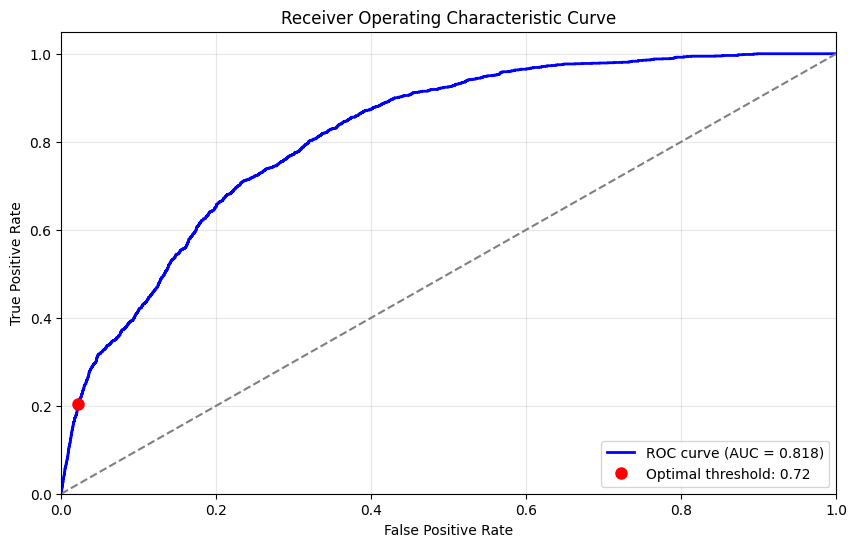

In [11]:
# Find optimal threshold based on F1 score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_balanced)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

# Handle case where thresholds might be empty
if len(thresholds) > 0:
    optimal_idx = np.argmax(f1_scores[:-1])  # Exclude the last point which has no threshold
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on F1 score: {optimal_threshold:.4f}")
    
    # Apply optimal threshold
    y_pred_optimal = (y_proba_balanced >= optimal_threshold).astype(int)
    
    print("\nPerformance with optimal threshold:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_optimal))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_optimal))
    
    # Fix for the ROC curve plot
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_balanced)
    roc_auc = roc_auc_score(y_test, y_proba_balanced)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Find the closest threshold value in ROC thresholds to our optimal threshold
    # This is the key fix - finding the right index in the ROC thresholds array
    closest_threshold_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))
    plt.plot(fpr[closest_threshold_idx], tpr[closest_threshold_idx], 'ro', markersize=8, 
            label=f'Optimal threshold: {optimal_threshold:.2f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Warning: Could not find optimal threshold - using default 0.5")
    y_pred_optimal = y_pred_balanced


Portfolio Performance Analysis:
Number of predicted doublings: 4643
True doublings: 357 (7.69%)
False doublings: 4286 (92.31%)

Detailed Portfolio Analysis:
True positive return statistics:
  - Mean: 1668.73%
  - Median: 417.28%
  - Min: 100.81%
  - Max: 27176.83%

False positive return statistics:
  - Mean: -31.94%
  - Median: -47.92%
  - Min: -89.66%
  - Max: 99.53%

Portfolio performance:
Expected portfolio return (equal-weighted): 470.65%
Market average return: -22.89%
Excess return: 493.54%


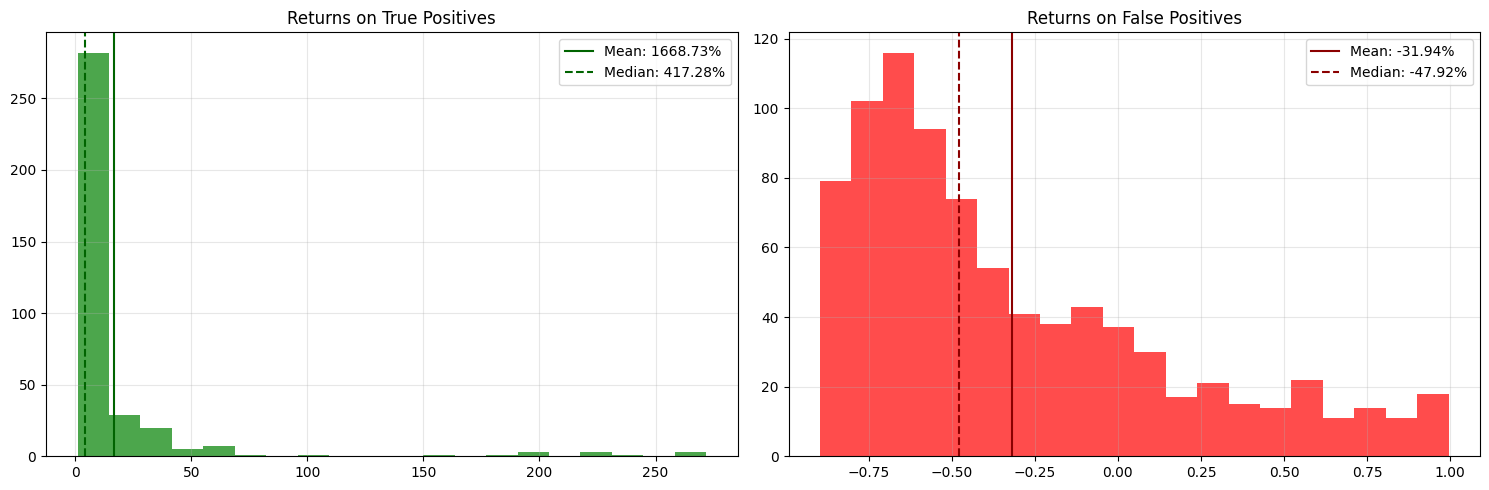

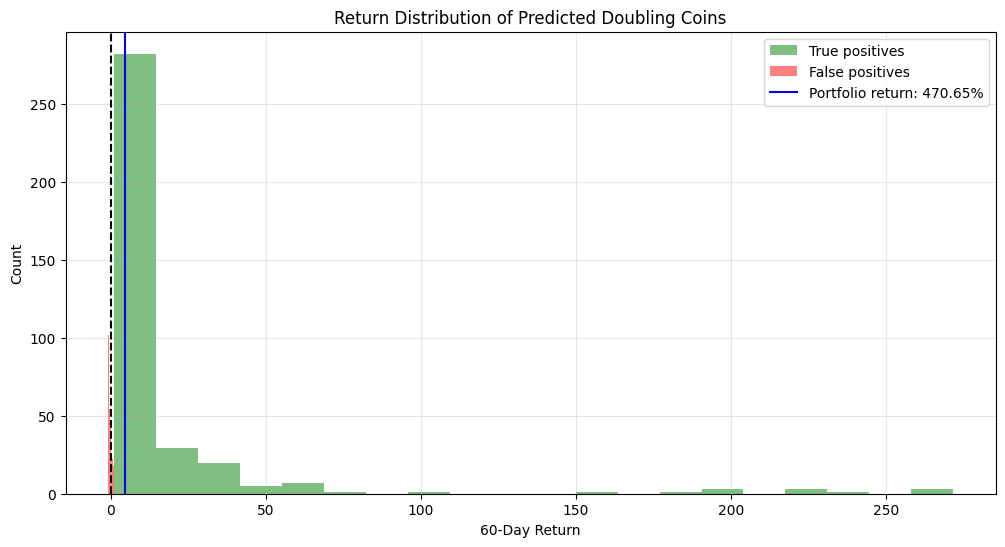

In [12]:
# Calculate expected returns based on predictions
test_results = test_data.copy()
test_results['prediction'] = y_pred_optimal
test_results['probability'] = y_proba_balanced
test_results['actual_return'] = test_results['future_price_60d'] / test_results['price'] - 1

# Get predicted positives
predicted_positives = test_results[test_results['prediction'] == 1]

# Fix: Proper filtering to avoid the warnings
true_positives = predicted_positives[predicted_positives['success'] == 1]
false_positives = predicted_positives[predicted_positives['success'] == 0]

print("\nPortfolio Performance Analysis:")
print(f"Number of predicted doublings: {len(predicted_positives)}")
print(f"True doublings: {len(true_positives)} ({len(true_positives)/len(predicted_positives):.2%})")
print(f"False doublings: {len(false_positives)} ({len(false_positives)/len(predicted_positives):.2%})")

# Calculate return statistics
true_positive_returns = true_positives['actual_return']
false_positive_returns = false_positives['actual_return']

print("\nDetailed Portfolio Analysis:")
print(f"True positive return statistics:")
print(f"  - Mean: {true_positive_returns.mean():.2%}")
print(f"  - Median: {true_positive_returns.median():.2%}")
print(f"  - Min: {true_positive_returns.min():.2%}")
print(f"  - Max: {true_positive_returns.max():.2%}")

print(f"\nFalse positive return statistics:")
print(f"  - Mean: {false_positive_returns.mean():.2%}")
print(f"  - Median: {false_positive_returns.median():.2%}")
print(f"  - Min: {false_positive_returns.min():.2%}")
print(f"  - Max: {false_positive_returns.max():.2%}")

# Calculate overall portfolio return (equal-weighted)
avg_portfolio_return = predicted_positives['actual_return'].mean()
market_return = test_results['actual_return'].mean()

print(f"\nPortfolio performance:")
print(f"Expected portfolio return (equal-weighted): {avg_portfolio_return:.2%}")
print(f"Market average return: {market_return:.2%}")
print(f"Excess return: {avg_portfolio_return - market_return:.2%}")

# Plot return distributions


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# True positives
ax1.hist(true_positive_returns, bins=20, color='green', alpha=0.7)
ax1.axvline(x=true_positive_returns.mean(), color='darkgreen', linestyle='-', 
            label=f'Mean: {true_positive_returns.mean():.2%}')
ax1.axvline(x=true_positive_returns.median(), color='darkgreen', linestyle='--', 
            label=f'Median: {true_positive_returns.median():.2%}')
ax1.set_title('Returns on True Positives')
ax1.legend()
ax1.grid(alpha=0.3)

# False positives
ax2.hist(false_positive_returns, bins=20, color='red', alpha=0.7)
ax2.axvline(x=false_positive_returns.mean(), color='darkred', linestyle='-', 
            label=f'Mean: {false_positive_returns.mean():.2%}')
ax2.axvline(x=false_positive_returns.median(), color='darkred', linestyle='--', 
            label=f'Median: {false_positive_returns.median():.2%}')
ax2.set_title('Returns on False Positives')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Add a combined return distribution chart
plt.figure(figsize=(12, 6))
plt.hist(true_positive_returns, bins=20, alpha=0.5, color='green', label='True positives')
plt.hist(false_positive_returns, bins=20, alpha=0.5, color='red', label='False positives')
plt.axvline(x=avg_portfolio_return, color='blue', linestyle='-', 
            label=f'Portfolio return: {avg_portfolio_return:.2%}')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('60-Day Return')
plt.ylabel('Count')
plt.title('Return Distribution of Predicted Doubling Coins')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Running sensitivity analysis...

1. Testing different probability thresholds


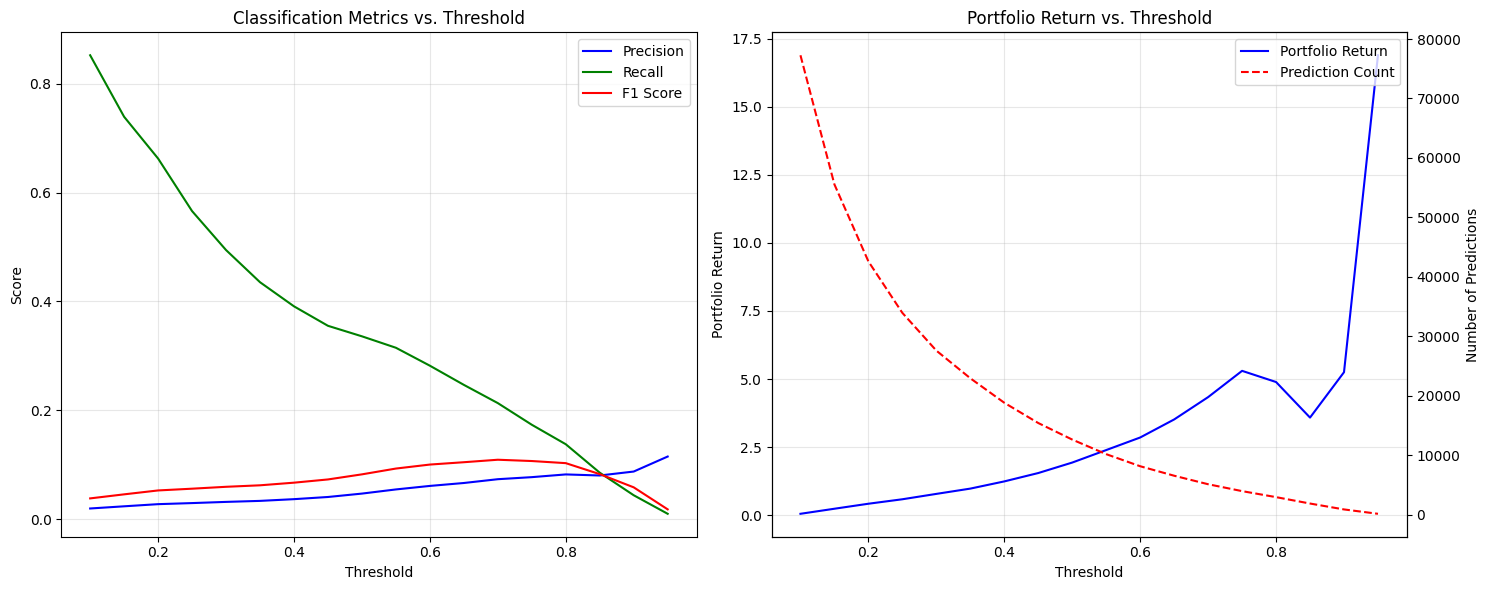


Optimal threshold for maximizing portfolio return: 0.9500
Portfolio return at optimal threshold: 1689.04%
Number of predictions at optimal threshold: 148
True positive rate at optimal threshold: 11.49%

2. Testing different model parameters
Testing Shallower Trees...
Testing Deeper Trees...
Testing Lower Min Child Weight...
Testing Higher Min Child Weight...
Testing Lower Learning Rate...
Testing Higher Learning Rate...

Parameter Sensitivity Results:
             parameter_set  portfolio_return   tp_rate  predictions
5     Higher Learning Rate          2.570589  0.079748         1906
2   Lower Min Child Weight          1.751707  0.032967          182
1             Deeper Trees          0.668305  0.050420          238
0          Shallower Trees          0.000000  0.000000            0
4      Lower Learning Rate          0.000000  0.000000            0
3  Higher Min Child Weight               NaN  0.000000           11


In [13]:
def sensitivity_analysis(X_train, y_train, X_test, y_test, test_data):
    """
    Perform sensitivity analysis by testing different thresholds and model parameters
    """

    
    print("Running sensitivity analysis...")
    
    # 1. Threshold sensitivity
    print("\n1. Testing different probability thresholds")
    
    # Train the baseline model (using the same parameters as your original model)
    baseline_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        random_state=42
    )
    
    baseline_model.fit(X_train, y_train)
    y_proba = baseline_model.predict_proba(X_test)[:, 1]
    
    # Test different thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        # Classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Portfolio metrics
        test_results = test_data.copy()
        test_results['prediction'] = y_pred
        test_results['actual_return'] = test_results['future_price_60d'] / test_results['price'] - 1
        
        # Calculate portfolio return
        pred_pos = test_results[test_results['prediction'] == 1]
        
        if len(pred_pos) > 0:
            true_pos = pred_pos[pred_pos['success'] == 1]
            false_pos = pred_pos[pred_pos['success'] == 0]
            
            tp_count = len(true_pos)
            fp_count = len(false_pos)
            
            # Calculate portfolio metrics
            if tp_count > 0:
                avg_tp_return = true_pos['actual_return'].mean()
            else:
                avg_tp_return = 0
                
            if fp_count > 0:
                avg_fp_return = false_pos['actual_return'].mean()
            else:
                avg_fp_return = 0
                
            portfolio_return = pred_pos['actual_return'].mean()
            
            # True positive rate
            tp_rate = tp_count / len(pred_pos) if len(pred_pos) > 0 else 0
        else:
            portfolio_return = 0
            tp_rate = 0
            avg_tp_return = 0
            avg_fp_return = 0
            tp_count = 0
            fp_count = 0
        
        result = {
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_return': portfolio_return,
            'predictions': len(pred_pos),
            'true_positives': tp_count,
            'false_positives': fp_count,
            'tp_rate': tp_rate,
            'avg_tp_return': avg_tp_return,
            'avg_fp_return': avg_fp_return
        }
        
        threshold_results.append(result)
    
    # Create dataframe of results
    threshold_df = pd.DataFrame(threshold_results)
    
    # Plot threshold sensitivity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot precision, recall, f1
    ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision')
    ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'g-', label='Recall')
    ax1.plot(threshold_df['threshold'], threshold_df['f1_score'], 'r-', label='F1 Score')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title('Classification Metrics vs. Threshold')
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Plot portfolio return and TP rate
    ax2.plot(threshold_df['threshold'], threshold_df['portfolio_return'], 'b-', label='Portfolio Return')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Portfolio Return')
    ax2.set_title('Portfolio Return vs. Threshold')
    ax2.grid(alpha=0.3)
    
    # Add secondary axis for prediction count
    ax3 = ax2.twinx()
    ax3.plot(threshold_df['threshold'], threshold_df['predictions'], 'r--', label='Prediction Count')
    ax3.set_ylabel('Number of Predictions')
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold for portfolio return
    optimal_idx = threshold_df['portfolio_return'].idxmax()
    optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
    
    print(f"\nOptimal threshold for maximizing portfolio return: {optimal_threshold:.4f}")
    print(f"Portfolio return at optimal threshold: {threshold_df.loc[optimal_idx, 'portfolio_return']:.2%}")
    print(f"Number of predictions at optimal threshold: {threshold_df.loc[optimal_idx, 'predictions']}")
    print(f"True positive rate at optimal threshold: {threshold_df.loc[optimal_idx, 'tp_rate']:.2%}")
    
    # 2. Parameter sensitivity
    print("\n2. Testing different model parameters")
    
    # Define parameter sets to test
    param_sets = [
        {'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.1, 'name': 'Shallower Trees'},
        {'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'name': 'Deeper Trees'},
        {'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.1, 'name': 'Lower Min Child Weight'},
        {'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'name': 'Higher Min Child Weight'},
        {'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.05, 'name': 'Lower Learning Rate'},
        {'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.2, 'name': 'Higher Learning Rate'},
    ]
    
    param_results = []
    
    for param_set in param_sets:
        name = param_set.pop('name')
        print(f"Testing {name}...")
        
        # Train model with these parameters
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            **param_set
        )
        
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Use the optimal threshold from earlier
        y_pred = (y_proba >= optimal_threshold).astype(int)
        
        # Classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Portfolio metrics
        test_results = test_data.copy()
        test_results['prediction'] = y_pred
        test_results['actual_return'] = test_results['future_price_60d'] / test_results['price'] - 1
        
        # Calculate portfolio return
        pred_pos = test_results[test_results['prediction'] == 1]
        
        if len(pred_pos) > 0:
            true_pos = pred_pos[pred_pos['success'] == 1]
            false_pos = pred_pos[pred_pos['success'] == 0]
            
            tp_count = len(true_pos)
            fp_count = len(false_pos)
            
            # Calculate portfolio metrics
            if tp_count > 0:
                avg_tp_return = true_pos['actual_return'].mean()
            else:
                avg_tp_return = 0
                
            if fp_count > 0:
                avg_fp_return = false_pos['actual_return'].mean()
            else:
                avg_fp_return = 0
                
            portfolio_return = pred_pos['actual_return'].mean()
            
            # True positive rate
            tp_rate = tp_count / len(pred_pos) if len(pred_pos) > 0 else 0
        else:
            portfolio_return = 0
            tp_rate = 0
            avg_tp_return = 0
            avg_fp_return = 0
            tp_count = 0
            fp_count = 0
        
        result = {
            'parameter_set': name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_return': portfolio_return,
            'predictions': len(pred_pos),
            'true_positives': tp_count,
            'false_positives': fp_count,
            'tp_rate': tp_rate,
            'avg_tp_return': avg_tp_return,
            'avg_fp_return': avg_fp_return
        }
        
        param_results.append(result)
    
    # Create dataframe of results
    param_df = pd.DataFrame(param_results)
    
    # Display parameter sensitivity results
    print("\nParameter Sensitivity Results:")
    print(param_df[['parameter_set', 'portfolio_return', 'tp_rate', 'predictions']].sort_values('portfolio_return', ascending=False))
    
    # Return all results
    return {
        'threshold_sensitivity': threshold_df,
        'parameter_sensitivity': param_df,
        'optimal_threshold': optimal_threshold
    }

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(X_resampled, y_resampled, X_test_selected, y_test, test_data)


=== Training Final Model with Optimal Parameters ===
Training final model with optimal parameters...
Training complete!

=== Classification Performance Metrics ===
Accuracy: 0.9836
Precision: 0.0797
Recall: 0.0864
F1 Score: 0.0829

Confusion Matrix:
[[201347   1754]
 [  1608    152]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    203101
           1       0.08      0.09      0.08      1760

    accuracy                           0.98    204861
   macro avg       0.54      0.54      0.54    204861
weighted avg       0.98      0.98      0.98    204861



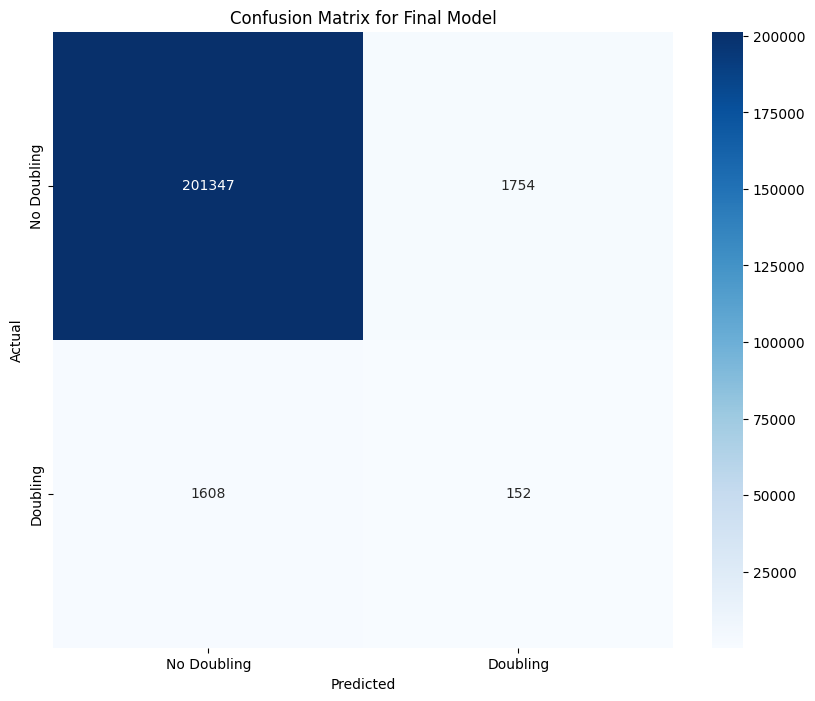


=== Portfolio Performance Analysis ===

Portfolio Composition:
Total predictions (investment opportunities): 1906
True doublings: 152 (7.97%)
False doublings: 1754 (92.03%)

Detailed Return Analysis for True Positives (Coins that actually doubled):
  - Count: 152
  - Mean Return: 1044.05%
  - Median Return: 422.01%
  - Min Return: 101.12%
  - Max Return: 7048.51%
  - Std Dev: 1461.71%

Detailed Return Analysis for False Positives (Coins that didn't double):
  - Count: 1754
  - Mean Return: -31.88%
  - Median Return: -44.41%
  - Min Return: -96.33%
  - Max Return: 99.34%
  - Std Dev: 47.26%

Overall Portfolio Performance:
Portfolio Mean Return: 257.06%
Portfolio Median Return: -13.17%
Market Average Return: -22.89%
Excess Return (alpha): 279.95%

Portfolio Growth:
Starting with $1000
Investing equally in 1906 cryptocurrencies
Final portfolio value: $3570.59
Total return: 257.06%

Risk Metrics:
Win Rate: 13.12%
Loss Rate: 16.58%
Profit Factor: 9.59
Standard Deviation: 894.68%


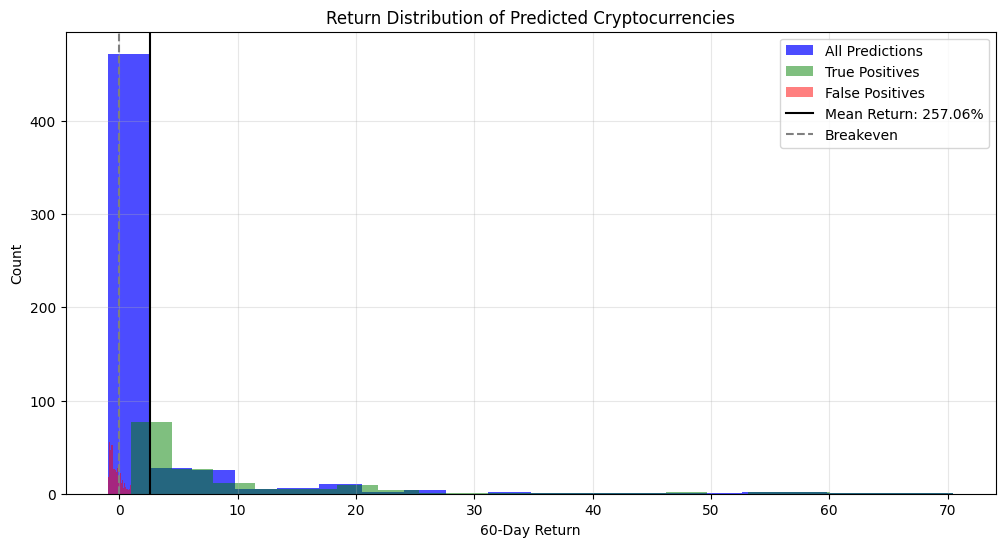

<Figure size 1200x800 with 0 Axes>

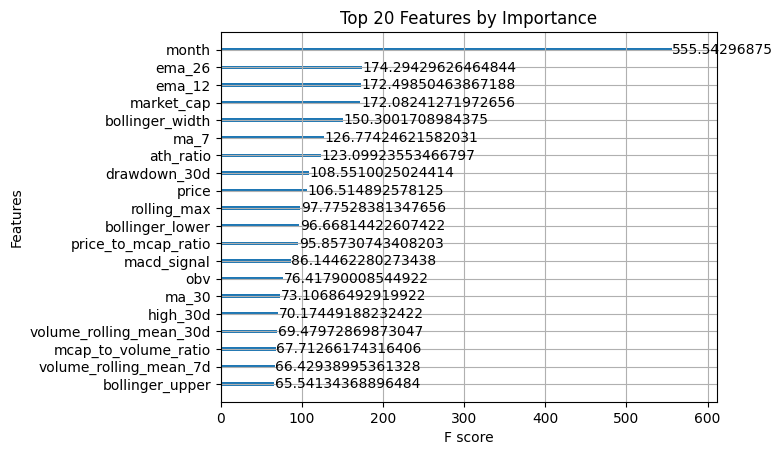

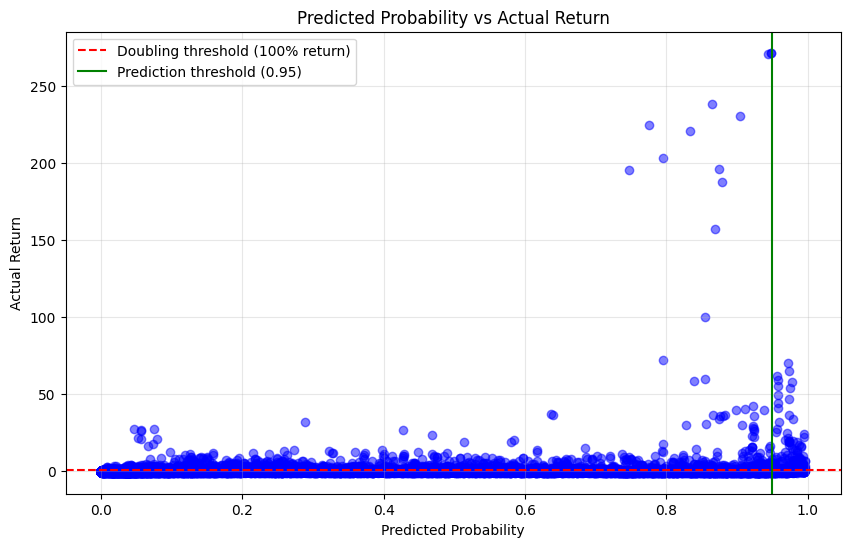

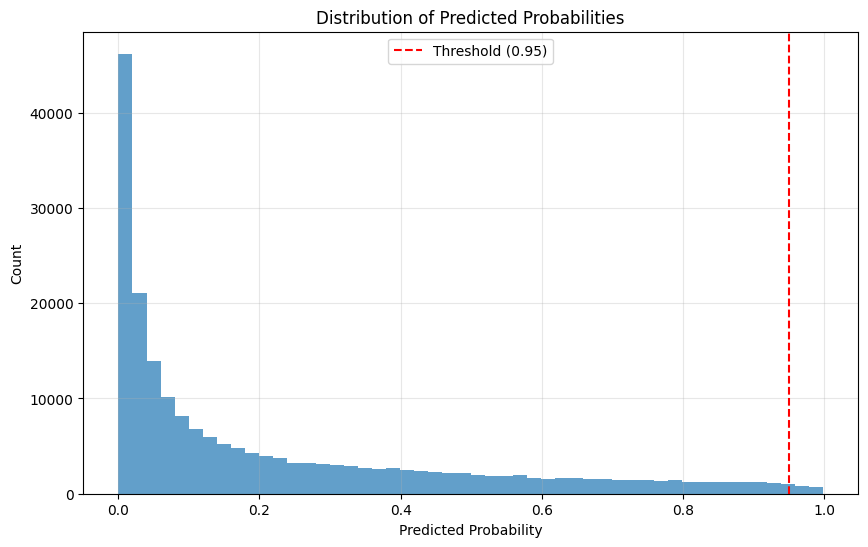


Final model saved as crypto_doubling_model.joblib

Top 10 Most Important Features:
            Feature  Importance
22            month    0.204259
10           ema_26    0.064084
9            ema_12    0.063423
1        market_cap    0.063270
14  bollinger_width    0.055262
6              ma_7    0.046612
19        ath_ratio    0.045261
21     drawdown_30d    0.039911
0             price    0.039163
18      rolling_max    0.035950


In [14]:
# Final Model with Optimal Parameters and Threshold
print("\n=== Training Final Model with Optimal Parameters ===")

# Define optimal parameters based on sensitivity analysis
optimal_params = {
    'objective': 'binary:logistic',
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.2,  # Higher learning rate (best performer)
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42
}

optimal_threshold = 0.95  # Optimal threshold from sensitivity analysis

# Train the final model
final_model = xgb.XGBClassifier(**optimal_params)
print("Training final model with optimal parameters...")
final_model.fit(X_resampled, y_resampled)
print("Training complete!")

# Get predictions with optimal threshold
y_proba_final = final_model.predict_proba(X_test_selected)[:, 1]
y_pred_final = (y_proba_final >= optimal_threshold).astype(int)

# Basic classification metrics
print("\n=== Classification Performance Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_final, zero_division=0):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

# Calculate classification metrics for each class
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))

# Create detailed confusion matrix visualization
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Doubling', 'Doubling'], 
            yticklabels=['No Doubling', 'Doubling'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Final Model')
plt.show()

# Create and analyze test results
print("\n=== Portfolio Performance Analysis ===")

# Create a dataframe with test data and predictions
test_results = test_data.copy()
test_results['prediction'] = y_pred_final
test_results['probability'] = y_proba_final
test_results['actual_return'] = test_results['future_price_60d'] / test_results['price'] - 1

# Get predicted positives (coins we would invest in)
predicted_positives = test_results[test_results['prediction'] == 1]

# Break down by true/false positives
true_positives = predicted_positives[predicted_positives['success'] == 1]
false_positives = predicted_positives[predicted_positives['success'] == 0]

print("\nPortfolio Composition:")
print(f"Total predictions (investment opportunities): {len(predicted_positives)}")
print(f"True doublings: {len(true_positives)} ({len(true_positives)/max(1, len(predicted_positives)):.2%})")
print(f"False doublings: {len(false_positives)} ({len(false_positives)/max(1, len(predicted_positives)):.2%})")

# If we have predicted positives, calculate returns
if len(predicted_positives) > 0:
    # Return statistics for true positives
    if len(true_positives) > 0:
        true_positive_returns = true_positives['actual_return']
        print("\nDetailed Return Analysis for True Positives (Coins that actually doubled):")
        print(f"  - Count: {len(true_positive_returns)}")
        print(f"  - Mean Return: {true_positive_returns.mean():.2%}")
        print(f"  - Median Return: {true_positive_returns.median():.2%}")
        print(f"  - Min Return: {true_positive_returns.min():.2%}")
        print(f"  - Max Return: {true_positive_returns.max():.2%}")
        print(f"  - Std Dev: {true_positive_returns.std():.2%}")
    else:
        print("\nNo true positives in the test set.")
    
    # Return statistics for false positives
    if len(false_positives) > 0:
        false_positive_returns = false_positives['actual_return']
        print("\nDetailed Return Analysis for False Positives (Coins that didn't double):")
        print(f"  - Count: {len(false_positive_returns)}")
        print(f"  - Mean Return: {false_positive_returns.mean():.2%}")
        print(f"  - Median Return: {false_positive_returns.median():.2%}")
        print(f"  - Min Return: {false_positive_returns.min():.2%}")
        print(f"  - Max Return: {false_positive_returns.max():.2%}")
        print(f"  - Std Dev: {false_positive_returns.std():.2%}")
    else:
        print("\nNo false positives in the test set.")
    
    # Overall portfolio statistics
    portfolio_returns = predicted_positives['actual_return']
    market_returns = test_results['actual_return']
    
    print("\nOverall Portfolio Performance:")
    print(f"Portfolio Mean Return: {portfolio_returns.mean():.2%}")
    print(f"Portfolio Median Return: {portfolio_returns.median():.2%}")
    print(f"Market Average Return: {market_returns.mean():.2%}")
    print(f"Excess Return (alpha): {portfolio_returns.mean() - market_returns.mean():.2%}")
    
    # Calculate portfolio value over time (assuming equal weighting)
    initial_investment = 1000  # $1000 starting capital
    equal_allocation = initial_investment / len(predicted_positives)
    final_value = initial_investment * (1 + portfolio_returns.mean())
    
    print(f"\nPortfolio Growth:")
    print(f"Starting with ${initial_investment}")
    print(f"Investing equally in {len(predicted_positives)} cryptocurrencies")
    print(f"Final portfolio value: ${final_value:.2f}")
    print(f"Total return: {(final_value/initial_investment - 1):.2%}")
    
    # Risk metrics
    win_rate = len(portfolio_returns[portfolio_returns > 0]) / len(portfolio_returns)
    loss_rate = len(portfolio_returns[portfolio_returns <= 0]) / len(portfolio_returns)
    profit_factor = abs(portfolio_returns[portfolio_returns > 0].sum() / portfolio_returns[portfolio_returns <= 0].sum()) if portfolio_returns[portfolio_returns <= 0].sum() != 0 else float('inf')
    
    print("\nRisk Metrics:")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Loss Rate: {loss_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Standard Deviation: {portfolio_returns.std():.2%}")
    
    # Plot return distributions
    plt.figure(figsize=(12, 6))
    plt.hist(portfolio_returns, bins=20, alpha=0.7, color='blue', label='All Predictions')
    
    if len(true_positives) > 0:
        plt.hist(true_positive_returns, bins=20, alpha=0.5, color='green', label='True Positives')
    
    if len(false_positives) > 0:
        plt.hist(false_positive_returns, bins=20, alpha=0.5, color='red', label='False Positives')
    
    plt.axvline(x=portfolio_returns.mean(), color='black', linestyle='-', 
                label=f'Mean Return: {portfolio_returns.mean():.2%}')
    plt.axvline(x=0, color='gray', linestyle='--', label='Breakeven')
    
    plt.xlabel('60-Day Return')
    plt.ylabel('Count')
    plt.title('Return Distribution of Predicted Cryptocurrencies')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Feature importance plot
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
    plt.title('Top 20 Features by Importance')
    plt.show()
    
    # Plot actual returns vs predicted probability
    plt.figure(figsize=(10, 6))
    plt.scatter(test_results['probability'], test_results['actual_return'], 
                alpha=0.5, color='blue')
    plt.axhline(y=1.0, color='red', linestyle='--', label='Doubling threshold (100% return)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='-', 
                label=f'Prediction threshold ({optimal_threshold})')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Return')
    plt.title('Predicted Probability vs Actual Return')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
    
    # Distribution of predicted probabilities
    plt.figure(figsize=(10, 6))
    plt.hist(test_results['probability'], bins=50, alpha=0.7)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
                label=f'Threshold ({optimal_threshold})')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Save the final model
   
    model_filename = 'crypto_doubling_model.joblib'
    joblib.dump(final_model, model_filename)
    print(f"\nFinal model saved as {model_filename}")
    
    # Create a record of the best features
    feature_importance = pd.DataFrame({
        'Feature': X_resampled.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
else:
    print("\nNo positive predictions were made with the current threshold.")
    print("Consider lowering the threshold to get some investment candidates.")